In [93]:
!pip install backtrader
!pip install pyfolio

     |████████████████████████████████| 419kB 23.4MB/s 
     |████████████████████████████████| 92kB 9.5MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2-cp36-none-any.whl size=88669 sha256=5f68885e960b1fdb8e6295efdbb13e4d03bca69ac6085ea1b6d9e32175f750d9
  Stored in directory: /root/.cache/pip/wheels/0d/a8/7d/ac33fe6bf6f3db370291c9de303460d00b8f97cc40a1d80f72
  Created wheel for empyrical: filename=empyrical-0.5.5-cp36-none-any.whl size=39765 sha256=bc24d25f324eb6dd899b29e68b458283b4414d26a412ad0554c503b4ecce97de
  Stored in directory: /root/.cache/pip/wheels/ea/b2/c8/6769d8444d2f2e608fae2641833110668d0ffd1abeb2e9f3fc
Successfully built pyfolio empyrical


In [1]:
data_path = '/content/drive/MyDrive/Colab Notebooks/datasets/bitcoin/'

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.layers as tl
import pyfolio as pf
import backtrader as bt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report

/usr/local/lib/python3.6/dist-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


In [2]:
def get_df(path):
    df = pd.read_csv(path)
    df = df.dropna()
    df = df.reset_index(drop=True)

    return df

In [44]:
btc = get_df(data_path + 'transformed_btc_5m.csv')

In [136]:
def create_target(df, lag=1):
    df_copy = df.copy()
    df_copy[f'returns_{lag}'] = np.log(df_copy.close / df_copy.close.shift(lag))
    df_copy[f'signal'] = np.where(df_copy[f'returns_{lag}'] > 0, 1, 0)

    df_copy.dropna(inplace=True)

    return df_copy

def create_splits(df, lag=1, pct_split=0.85, normalize=True):
    df_copy = df.copy()
    
    # Firts separate the target
    target_columns = [f'returns_{lag}', 'signal', 'open_time']
    targets = df_copy[target_columns]
    df_copy.drop(target_columns, axis=1, inplace=True)
    columns = df_copy.columns

    split = int(len(df_copy) * pct_split)
    train = df_copy.iloc[:split]
    train_targets = targets.iloc[:split]
    test = df_copy.iloc[split:]
    test_targets = targets.iloc[split:]

    if normalize:
        #scaler = MinMaxScaler()
        scaler = StandardScaler()
        train = scaler.fit_transform(train)
        test = scaler.transform(test)
        train = pd.DataFrame(train, columns=columns)
        test = pd.DataFrame(test, columns=columns)

    print(f'train shape: {train.shape}')
    print(f'test shape: {test.shape}')

    return train, test, train_targets, test_targets, scaler

In [137]:
lag = 1

df = create_target(btc, lag=lag)
X_train, X_test, y_train, y_test, scaler = create_splits(df, pct_split=0.95, lag=lag)

train shape: (342197, 56)
test shape: (18011, 56)


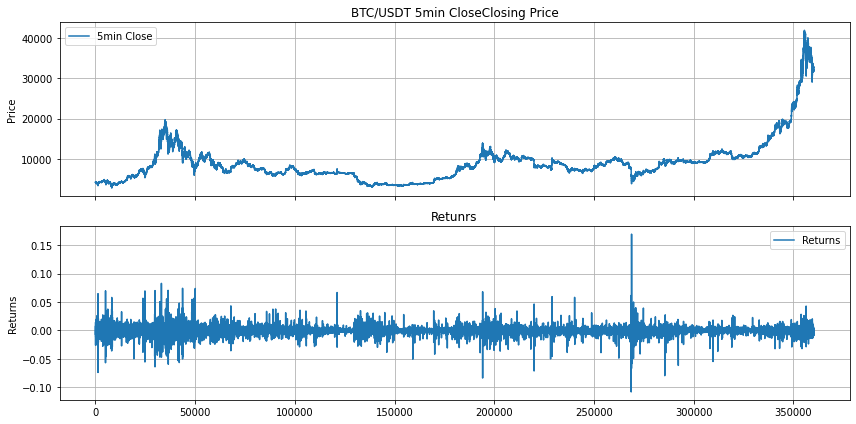

In [138]:
# visualize the closing price and daily returns
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (12,6))
ax[0].plot(df.close, label='5min Close')
ax[0].set(title = 'BTC/USDT 5min CloseClosing Price', ylabel = 'Price')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(df[f'returns_{lag}'], label = 'Returns')
ax[1].set(title = 'Retunrs', ylabel = 'Returns')
ax[1].grid(True)
plt.legend()

plt.tight_layout();

In [139]:
def create_model(layer_units=None, dropout=True, 
                 rate=0.3, regularize=False, reg=None,
                 optimizer=None, input_dim=None):
    
    input = tl.Input(shape=input_dim)
    if regularize:
        x = tl.Dense(layer_units[0], activation='relu', kernel_regularizer=reg)(input)
    else:
        x = tl.Dense(layer_units[0], activation='relu', )(input)

    if dropout:
        x = tl.Dropout(rate)(x)
        
    for units in range(1, len(layer_units)):
        if regularize:
            x = tl.Dense(units, activation='relu', kernel_regularizer=reg)(x)
        else:
            x = tl.Dense(units, activation='relu')(x)

        if dropout:
            x = tl.Dropout(rate)(x)

    output = tl.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input, outputs=output)

    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                    metrics=['accuracy'])
  
    return model

# Check for imbalanced data 

In [98]:
print(df.signal.value_counts())

1    180135
0    180073
Name: signal, dtype: int64


In [153]:
regularizer = l2(0.01)
layer_units = [32, 64, 128]

model = create_model(layer_units=layer_units, dropout=True, rate=0.2, 
                     regularize=True, reg=regularizer, optimizer='adam',
                     input_dim=X_train.shape[1])

model.fit(X_train, y_train.signal.values,
          batch_size=512, epochs=10, verbose=1,
          validation_split=0.15, shuffle=True)

Epoch 1/10
569/569 [==============================] - 2s 3ms/step - loss: 0.8631 - accuracy: 0.5742 - val_loss: 0.5872 - val_accuracy: 0.7375
Epoch 2/10
569/569 [==============================] - 2s 3ms/step - loss: 0.6309 - accuracy: 0.6509 - val_loss: 0.5631 - val_accuracy: 0.7374
Epoch 3/10
569/569 [==============================] - 2s 3ms/step - loss: 0.6246 - accuracy: 0.6517 - val_loss: 0.5602 - val_accuracy: 0.7447
Epoch 4/10
569/569 [==============================] - 2s 3ms/step - loss: 0.6216 - accuracy: 0.6533 - val_loss: 0.5596 - val_accuracy: 0.7376
Epoch 5/10
569/569 [==============================] - 2s 3ms/step - loss: 0.6219 - accuracy: 0.6502 - val_loss: 0.5612 - val_accuracy: 0.7301
Epoch 6/10
569/569 [==============================] - 2s 4ms/step - loss: 0.6197 - accuracy: 0.6532 - val_loss: 0.5520 - val_accuracy: 0.7442
Epoch 7/10
569/569 [==============================] - 2s 3ms/step - loss: 0.6169 - accuracy: 0.6542 - val_loss: 0.5538 - val_accuracy: 0.7398
Epoch 

In [154]:
preds = model.predict(X_test)

In [155]:

predictions = pd.DataFrame({'y_true': y_test.signal.values, 'probs': preds.squeeze(), })
predictions['preds'] = np.where(predictions.probs > 0.7, 1, 0)
predictions

,y_true,probs,preds
0,1,0.811610,1
1,1,0.524051,0
2,1,0.536008,0
3,0,0.375100,0
4,0,0.468777,0
...,...,...,...
18006,1,0.761130,1
18007,0,0.375100,0
18008,1,0.465051,0
18009,1,0.483844,0


In [156]:
confusion_matrix(predictions.y_true, predictions.preds)

array([[8759,  110],
       [6018, 3124]])

In [157]:
print(classification_report(predictions.y_true, predictions.preds))

              precision    recall  f1-score   support

           0       0.59      0.99      0.74      8869
           1       0.97      0.34      0.50      9142

    accuracy                           0.66     18011
   macro avg       0.78      0.66      0.62     18011
weighted avg       0.78      0.66      0.62     18011



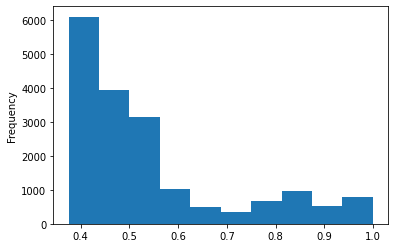

In [158]:
predictions.probs.plot(kind='hist')

In [171]:
test = X_test.copy()
# inverse the scale 
data = scaler.inverse_transform(test.values)
test = pd.DataFrame(data, columns=X_test.columns)

test['open_time'] = y_test.open_time.values
test['direction'] = predictions.preds
test['returns'] = y_test['returns_1'].values
test['position_strategy'] = np.where(test.direction > 0, 1, -1)
test['strategy_returns'] = test['position_strategy'] * test['returns']


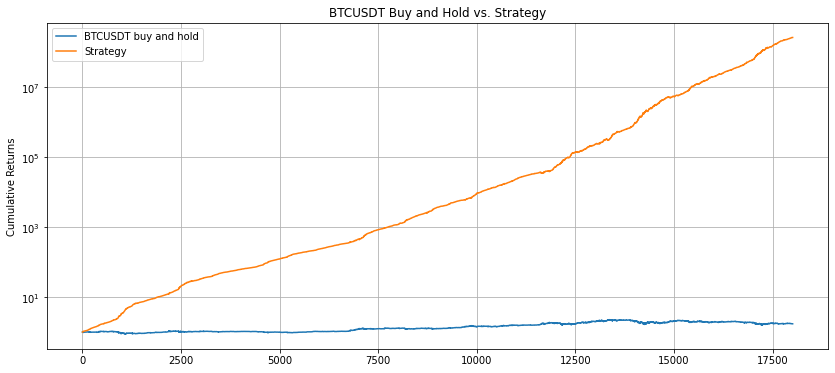

In [160]:
# plot cumulative returns
fig, ax = plt.subplots(1, 1, sharex=True, figsize = (14,6))
ax.plot(test.returns.cumsum().apply(np.exp), label = 'BTCUSDT buy and hold')
ax.plot(test.strategy_returns.cumsum().apply(np.exp), label = 'Strategy')
ax.set(title = 'BTCUSDT Buy and Hold vs. Strategy', ylabel = 'Cumulative Returns')
ax.grid(True)
ax.legend()
plt.yscale('log')
#plt.savefig('images/chart2');

In [201]:
columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'direction', 'returns' ]
backtest = test[columns].copy()
backtest['open_time'] = pd.to_datetime(backtest['open_time'])
backtest.set_index('open_time', inplace=True)
backtest.head()

,open,high,low,close,volume,direction,returns
open_time,,,,,,,
2020-11-22 23:25:00,18400.00,18496.53,18399.99,18486.02,389.267475,1,0.004664
2020-11-22 23:30:00,18486.02,18538.75,18473.75,18488.65,325.105011,0,0.000142
2020-11-22 23:35:00,18488.64,18537.33,18486.84,18511.21,191.753204,0,0.001219
2020-11-22 23:40:00,18511.20,18520.43,18460.27,18461.73,137.788283,0,-0.002677
2020-11-22 23:45:00,18461.74,18475.00,18422.72,18430.99,207.886029,0,-0.001666


In [183]:
from backtrader.feeds import PandasData

OHLCV = ['open', 'high', 'low', 'close', 'volume']

# class to define the columns we will provide
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['direction']

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

Strategy: 
1.	Buy when the predicted value is +1 and sell (only if stock is in possession) when the predicted value is 0.
2.	All-in strategy—when creating a buy order, buy as many shares as possible.
3.	Short selling is not allowed

In [193]:
# define backtesting strategy class
class MLStrategy(bt.Strategy):
    params = dict(
    )
    
    def __init__(self):
        # keep track of the data
        self.data_predicted = self.datas[0].direction
        self.data_open = self.datas[0].open
        self.data_close = self.datas[0].close
        
        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None
        self.pristine_candles = []

    # logging function
    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    # We have set cheat_on_open = True.This means that we calculated the signals on day t's close price, 
    # but calculated the number of shares we wanted to buy based on day t+1's open price.
    def next_open(self):

      
        if not self.position:
            if self.data_predicted == 1:
                # calculate the max number of shares ('all-in')
                #size = int(self.broker.getcash() / self.datas[0].open)
                # buy order
#                 self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy()
        else:
            if self.data_predicted == 0:
                # sell order
#                 self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)

In [194]:
# instantiate SignalData class
data = SignalData(dataname=backtest)

In [195]:
# instantiate Cerebro, add strategy, data, initial cash, commission and pyfolio for performance analysis
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)
cerebro.addstrategy(MLStrategy)
cerebro.adddata(data, name='BTC/USDT')
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

In [196]:
# run the backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Se han truncado las últimas 5000 líneas del flujo de salida.
2020-12-13, OPERATION RESULT --- Gross: 15.79, Net: -21.88
2020-12-13, BUY EXECUTED --- Price: 18886.95, Cost: 18886.95,Commission: 18.89
2020-12-13, SELL EXECUTED --- Price: 18912.06, Cost: 18886.95,Commission: 18.91
2020-12-13, OPERATION RESULT --- Gross: 25.11, Net: -12.69
2020-12-13, BUY EXECUTED --- Price: 18849.99, Cost: 18849.99,Commission: 18.85
2020-12-13, SELL EXECUTED --- Price: 18878.55, Cost: 18849.99,Commission: 18.88
2020-12-13, OPERATION RESULT --- Gross: 28.56, Net: -9.17
2020-12-13, BUY EXECUTED --- Price: 18870.52, Cost: 18870.52,Commission: 18.87
2020-12-13, SELL EXECUTED --- Price: 18904.80, Cost: 18870.52,Commission: 18.90
2020-12-13, OPERATION RESULT --- Gross: 34.28, Net: -3.50
2020-12-13, BUY EXECUTED --- Price: 18903.02, Cost: 18903.02,Commission: 18.90
2020-12-13, SELL EXECUTED --- Price: 18925.39, Cost: 18903.02,Commission: 18.93
2020-12-13, OPERATION RESULT --- Gross: 22.37, Net: -15.46
2020-12-13

In [197]:
# Extract inputs for pyfolio
strat = backtest_result[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.name = 'Strategy'
returns.head(2)

index
2020-11-22 00:00:00+00:00    0.000000
2020-11-23 00:00:00+00:00    0.008334
Name: Strategy, dtype: float64

In [200]:
# get performance statistics for strategy
pf.show_perf_stats(returns)

Start date,2020-11-22
End date,2021-01-24
Total months,3
,Backtest
Annual return,3288.2%
Cumulative returns,144.7%
Annual volatility,19.0%
Sharpe ratio,18.75
Calmar ratio,10893.84
Stability,0.91
Max drawdown,-0.3%
